In [1]:
import os
import json
import requests
import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.colors as colors
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon
from pyproj import Proj
from dotenv import load_dotenv

plt.rcParams["font.family"] = "Times New Roman"

load_dotenv(dotenv_path=".env")
POSITIONSTACK_API_KEY = os.getenv("POSITIONSTACK_API_KEY")

In [2]:
# read italian regions shapes
ita = gpd.read_file("italian-maps-shapefiles/italy-with-regions/reg2011_g.shp")

# get lombardia shape
lmb = ita[ita["NOME_REG"]=="LOMBARDIA"]

# get lombardia with provinces shape
lmb_p = gpd.read_file("italian-maps-shapefiles/regions-with-provinces/lombardia/lombardia.shp")
lmb_p.columns = lmb_p.columns.str.lower()

# add number of intervention per province
lmb_p["interventi"] = [0,0,14,0,0,0,0,0,1,3,3,2]

# lowercase nome_pro
lmb_p.nome_pro = lmb_p.nome_pro.str.lower()

# show
lmb_p

,cod_reg,cod_pro,nome_pro,shape_leng,shape_area,geometry,interventi
0,3,13,como,260843.128783,1.279089e+09,"MULTIPOLYGON (((521630.187 5120831.002, 521739...",0
1,3,12,varese,245849.447397,1.199042e+09,"POLYGON ((483154.593 5104805.000, 483341.500 5...",0
2,3,15,milano,309551.691373,1.575269e+09,"MULTIPOLYGON (((495404.523 5054547.920, 495509...",14
3,3,18,pavia,450740.523680,2.968156e+09,"MULTIPOLYGON (((488156.944 5026523.092, 488089...",0
4,3,16,bergamo,311027.307255,2.745545e+09,"POLYGON ((585372.000 5104682.001, 585498.437 5...",0
5,3,17,brescia,446983.163682,4.788497e+09,"POLYGON ((615380.000 5132540.001, 615458.001 5...",0
6,3,14,sondrio,463732.642719,3.194588e+09,"POLYGON ((595736.187 5163715.001, 596126.251 5...",0
7,3,19,cremona,366194.655471,1.768850e+09,"POLYGON ((542272.999 5037561.001, 542491.811 5...",0
8,3,20,mantova,386614.325919,2.340971e+09,"POLYGON ((630623.077 5031867.982, 632904.000 5...",1
9,3,108,monza e della brianza,126136.532417,4.055762e+08,"POLYGON ((519838.001 5065441.000, 520283.000 5...",3


In [3]:
# init cities where interventions took place
cities = pd.DataFrame({
    "city":["caponago","lecco","linate","mantova","meda","monza","pavia","vigevano","voghera"]
})

# function to get region, lat and lng from API
def fetch_api_data(row):
    loc=f"{row.city}, Italy"
    url = f"http://api.positionstack.com/v1/forward?access_key={POSITIONSTACK_API_KEY}&query={loc}"
    r = requests.get(url)
    data = json.loads(r.text)
    return pd.Series([
        data.get("data")[0].get("region"),
        data.get("data")[0].get("latitude"),
        data.get("data")[0].get("longitude")]
    )

# add region, lat and lng
cities = pd.concat([
    cities,
    cities.apply(fetch_api_data, axis=1)
        .apply(pd.Series)
        .rename(columns={0:"nome_pro",1:"lat",2:"lng"})
], axis=1)

# lowercase nome_pro
cities.nome_pro = cities.nome_pro.str.lower()

# show
cities

,city,nome_pro,lat,lng
0,caponago,monza e della brianza,45.567646,9.376730
1,lecco,lecco,45.852756,9.403077
2,linate,milano,45.454326,9.275213
3,mantova,mantova,45.155159,10.793588
4,meda,monza e della brianza,45.656255,9.163112
5,monza,monza e della brianza,45.581513,9.264031
6,pavia,pavia,45.188029,9.156490
7,vigevano,pavia,45.315809,8.858918
8,voghera,pavia,44.991171,9.009182


In [4]:
# init converter (from lat, ln to utm)
pp = Proj(proj='utm', zone=32, ellps='WGS84', preserve_units=True)

# add utms
cities = pd.concat([
    cities,
    cities.apply(lambda x: pp(x.lng, x.lat), axis=1).apply(pd.Series)
], axis=1)

# rename columns
cities = cities.rename(columns={0:"utm_e",1:"utm_n"})

# get geo data
cities_geo = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.utm_e, cities.utm_n))

# show
display(cities_geo)

,city,nome_pro,lat,lng,utm_e,utm_n,geometry
0,caponago,monza e della brianza,45.567646,9.376730,529397.440291,5.046081e+06,POINT (529397.440 5046080.837)
1,lecco,lecco,45.852756,9.403077,531293.863589,5.077767e+06,POINT (531293.864 5077766.872)
2,linate,milano,45.454326,9.275213,521518.887498,5.033459e+06,POINT (521518.887 5033459.109)
3,mantova,mantova,45.155159,10.793588,640980.030546,5.001752e+06,POINT (640980.031 5001751.626)
4,meda,monza e della brianza,45.656255,9.163112,512708.122034,5.055869e+06,POINT (512708.122 5055869.156)
5,monza,monza e della brianza,45.581513,9.264031,520598.110021,5.047586e+06,POINT (520598.110 5047586.325)
6,pavia,pavia,45.188029,9.156490,512293.398640,5.003850e+06,POINT (512293.399 5003850.294)
7,vigevano,pavia,45.315809,8.858918,488941.833569,5.018043e+06,POINT (488941.834 5018043.431)
8,voghera,pavia,44.991171,9.009182,500723.793184,4.981970e+06,POINT (500723.793 4981969.652)


In [5]:
# add data
cities_geo["workers"] = [1,1,1,1,1,1,1,1,1]

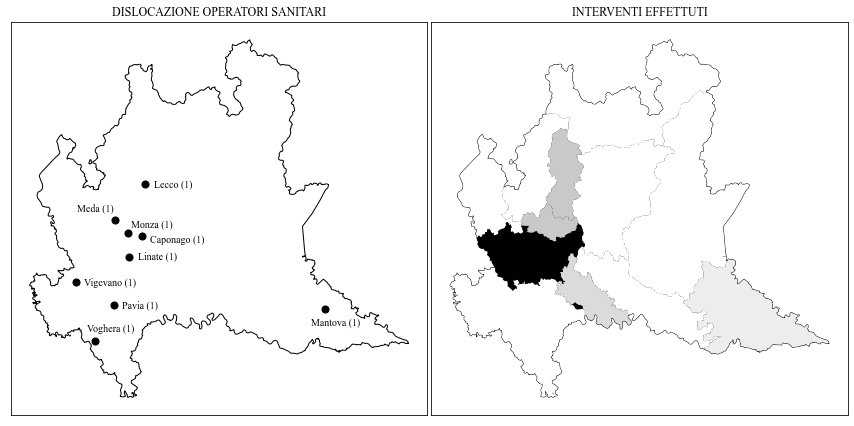

In [6]:
# init figure and axes
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))

# plot lombardia without provinces
lmb.plot(facecolor="#fff", edgecolor="#000", ax=ax1)

# plot lombardia without provinces
lmb_p.plot(facecolor="#fff", edgecolor="#000", ax=ax2)

# plot cities where interventions took place
cities_geo.plot(marker="o", markersize=50, color="#000", ax=ax1)

# add annotation of each city
annot_offset=[(5,-4),(5,-2),(5,-2),(-9,-10),(-23,5),(2,3.8),(5,-2),(5,-2),(-5,6)]
annot_offset=[(x*1e3, y*1e3) for (x,y) in annot_offset]
for (ox, oy), (idx, row) in zip(annot_offset, cities_geo.iterrows()):
    ax1.annotate(f"{row.city.capitalize()} ({row.workers})",(row.utm_e + ox, row.utm_n + oy))

# cloropleth of interventions
lmb_p.plot(column='interventi', cmap='gray_r', ax=ax2)

# customize axes
for ax in (ax1,ax2):
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
#set titles
ax1.set_title("Dislocazione operatori sanitari".upper())
ax2.set_title("Interventi effettuti".upper())

# reduce horizontal space
fig.subplots_adjust(wspace=0.01)

# save
plt.savefig("geografia interventi.pdf", bbox_inches='tight',pad_inches=0)